# Best combination of high demand and high pay for Data Analysts

In [75]:
# Importing Libraries
from adjustText import adjust_text
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

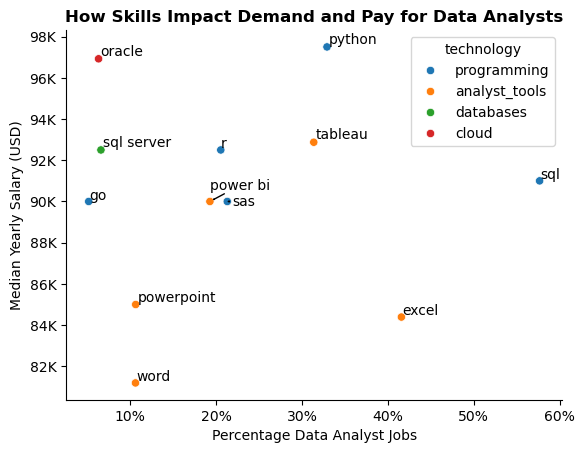

In [83]:
# Filter by country and location
df_da_us = df[(df["job_country"] == "United States") & (df["job_title_short"] == "Data Analyst")].dropna(subset="salary_year_avg").copy()
# Convert job_skills column values from a list to individual ones.
df_da_us_exp = df_da_us.explode("job_skills")
# DataFrame with count and median from job_skills
df_da_us_exp = df_da_us_exp.groupby("job_skills")["salary_year_avg"].agg(["count", "median"]).sort_values("count", ascending=False)
df_da_us_exp = df_da_us_exp.rename(columns={"count": "skill_count", "median": "median_salary"})
# DataFrame in percentage format and only considering those ones higher than 4%
df_da_us_exp["skill_percent"] = df_da_us_exp["skill_count"] / len(df_da_us) * 100
df_da_us_exp = df_da_us_exp[df_da_us_exp["skill_percent"] >= 5]

# Preparing data for another DataFrame
df_job_type = df["job_type_skills"].drop_duplicates().dropna().copy()
# Extracting unique job type skills
technology_dict = {}
for row in df_job_type:
    row_dict = ast.literal_eval(row)
    if isinstance(row_dict, dict):
        for key, value in row_dict.items():
            if key in technology_dict:
                technology_dict[key] += value
            else:
                technology_dict[key] = value
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))
# DataFrame with job type skills
df_tech = pd.DataFrame(list(technology_dict.items()), columns=["technology", "skills"])
df_tech = df_tech.explode("skills")
# Merging both first and job type skills DataFrames
df_plot = df_da_us_exp.merge(df_tech, left_on="job_skills", right_on="skills")

# Plotting
sns.scatterplot(data=df_plot, x="skill_percent", y="median_salary", hue="technology")
sns.despine()

## Plot labels
texts =[]
for i, txt in enumerate(df_da_us_exp.index):
    text = plt.text(df_da_us_exp["skill_percent"].iloc[i], df_da_us_exp["median_salary"].iloc[i], txt)
    texts.append(text)
## Adjust label text
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

## Labeling
plt.xlabel("Percentage Data Analyst Jobs"), plt.ylabel("Median Yearly Salary (USD)"), plt.title("How Skills Impact Demand and Pay for Data Analysts", weight="bold")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x)}%'))
plt.show()